Link do notatnika: https://colab.research.google.com/drive/1ZHSiH8VVMjNSlSM-_jk-trcCKBM-32AE?usp=sharing

---


# Wstęp
Zadanie 7 stanowi wprowadzenie w tematykę transfer learning i wykorzystywania gotowych, publicznie udostępnianych modeli. W praktyce, dla zadań tak złożonych jak analiza obrazu, o wiele łatwiej jest dostosować istniejące już i wyuczone na dużych zbiorach danych modele do nowego zaadania, niż wyuczyć własny model od zera. Jako bardziej interesujący przykład zastosowania gotowych modeli zostanie pokazany też transfer stylu obrazów.

#Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    mechanizmem importowania modeli
*    możliwościami wykorzystaniem transfer learningu do własnych zadań
*    transferem stylu jako przykładem wykorzystania cech z zamrożonej architektury

# Importowanie modeli

Importowanie w torchu realizować będziemy poprzez ładowanie zapisanego obiektu słownika z wszystkimi parametrami warstw. Warto pamiętać tutaj, że słownik ten nie zapamiętuje pełnej struktury sieci, a jedynie parametry! Dlatego z jednej strony dla wczytania gotowego modelu konieczne jest istnienie odpowiedniej architektury w kodzie (zaimplementowany `torch.nn.Module` realizujący tę architekturę). Z drugiej zaś, słownik parametrów zgodny pod względem nazw i kształtów parametrów z zadaną architekturą możemy wczytać do dowolnej, dostosowanej do naszych potrzeb klasy - w szczególności umożliwiając nam własną implementację `forward`. Na razie sprawdźmy model, który ma już swoją implementację w `torchvision`: klasyczną architekturę VGG.

In [ ]:
import torch
import torchvision.models as models
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from google.colab import drive
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
vgg19 = models.vgg19(pretrained=True)

print(vgg19)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 282MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

W kontekście vgg19, interesuje nas szczególnie moduł features: instancja `torch.nn.Sequential', obejmująca konwolucyjną część architektury. Dla nowych zadań analizy obrazów, możemy wykorzystać tę częśc z własnym klassyfikatorem.

In [ ]:
print(vgg19.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Tutaj warto zwrócić jeszcze uwagę na przydatną własność `torch.nn.Sequential`: ta klasa jest indeksowalna, a kiedy korzystamy z indeksowania aby zwócić ciąg następujących po sobie elementów, zwracana jest również instancja `torch.nn.Sequential`:

In [ ]:
print(f"pod indeksem 3 jest: {vgg19.features[3]}")
print(f"pod indeksami 3 do 7 jest: {vgg19.features[3:7]}")

pod indeksem 3 jest: ReLU(inplace=True)
pod indeksami 3 do 7 jest: Sequential(
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
)


# Zadanie 1

Zdefiniuj klasę LabVGG19, która inicjalizuje swoje parametry poprzez wczytanie wyuczonego modelu z torchvision.models, ale jej `forward` zwraca na wyjściu krotkę lub listę `out` gdzie



*   `out[0]` - cechy z poziomu architektury poprzedzającego pierwszy Max Pooling
*    `out[1]` - cechy z poziomu architektury poprzedzającego drugi Max Pooling
*    `out[2]` - cechy z poziomu architektury poprzedzającego trzeci Max Pooling


In [ ]:
class LabVGG19(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.model = vgg19.features

  def forward(self, x):
    out = []
    for idx, module in enumerate(self.model):
      x = module(x)
      if idx in [2,7,12]:
        out.append(x)
    return out

Zweryfikuj działanie architektury

In [ ]:
model = LabVGG19()
dummy_input = torch.zeros((3,3,32,32))
out = model(dummy_input)

assert(out[0].shape == (3,64,32,32))
assert(out[1].shape == (3,128,16,16))
assert(out[2].shape == (3,256,8,8))

# Transfer Learning

Mając możliwość wydobywania cech z dowolnego poziomu architektury, możemy łatwo wykorzystać je do dowolnych nowych zadań. Wystarczy zbudować model, który przetwarza jako wejście to, co wynika z naszego wcześniejszego przetwarzania przez wyuczoną już sieć. Zaimportowaną część sieci możemy zarówno **douczać** jak i **zamrozić** w zależności od tego czy jej parametry podamy przy naszym uczeniu do optymalizowania. W tym drugim przypadku, warto pamiętać o wyłączeniu gradientów dla zamrożonych warstw.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.


**VGG na wejściu oczekuje danych znormalizowanych, z określonymi wartościami średniej i odchylenia standardowego. Transformacja wejściowa powinna korzystać z `transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))`.**

In [ ]:
device = torch.device('cuda')
device

device(type='cuda')

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:

transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

test_ds, val_ds = train_test_split(test_ds, test_size=0.5)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=32, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module,
    loss_fn: torch.nn.CrossEntropyLoss,
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch).sum()
        correct += count_correct(y_pred, y_batch)
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer,
    loss_fn: torch.nn.CrossEntropyLoss, train_loader: DataLoader,
    dev_loader: DataLoader, epochs: int, patience: int,
    print_metrics: str = True
):
    loss_train_log=[]
    acc_train_log=[]
    loss_dev_log=[]
    acc_dev_log=[]

    best_loss = np.inf
    num_patience = 1

    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch) # Uzyskanie pseudoprawdopodobieństw dla próbek z minibatcha
            loss = loss_fn(y_pred, y_batch) # Policzenie funkcji straty

            loss.backward() # Wsteczna propagacja z wyniku funkcji straty - policzenie gradientów i zapisanie ich w tensorach (parametrach)
            optimiser.step() # Aktualizacja parametrów modelu przez optymalizator na podstawie gradientów zapisanych w tensorach (parametrach) oraz lr
            optimiser.zero_grad() # Wyzerowanie gradientów w modelu, alternatywnie można wywołać percepron.zero_grad()

        if print_metrics:
            model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
            with torch.no_grad():  # Wstrzymujemy przeliczanie i śledzenie gradientów dla tensorów - w procesie ewaluacji modelu nie chcemy zmian w gradientach
                train_loss, train_acc = validate(model, loss_fn, train_loader)
                dev_loss, dev_acc = validate(model, loss_fn, dev_loader)
                print(
                    f"Epoch {epoch+1}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {dev_loss:.3f} (acc: {dev_acc:.3f})"
                )
                loss_train_log.append(round(float(train_loss.cpu()),4))
                acc_train_log.append(round(float(train_acc.cpu()),4))
                loss_dev_log.append(round(float(dev_loss.cpu()),4))
                acc_dev_log.append(round(float(dev_acc.cpu()),4))

        if  dev_loss < best_loss:
            print(f'Zapisujemy model z acc={dev_acc}, loss={dev_loss}, po epoce:{epoch+1}\n')
            best_loss = dev_loss
            num_patience = 0
            torch.save(
                obj={
                    'epoch': epoch,
                    'loss': dev_loss,
                    'acc': dev_acc,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict()
                    }, f='/content/drive/MyDrive/lab05/model_checkopint.pth'
                    )
        else:
            num_patience += 1
            print(f'Model nie poprawił się od: {num_patience} epok.\n')

        if num_patience >= patience:
            print(f'Koniec uczenia')
            break

    model.eval() # Przełączenie na tryb ewaluacji modelu - istotne dla takich warstw jak Dropuot czy BatchNorm
    epoch_list = np.arange(1, epochs+1)
    return epoch_list, loss_train_log, acc_train_log, loss_dev_log, acc_dev_log

100%|██████████| 170498071/170498071 [00:05<00:00, 29073253.25it/s]


Extracting cifar_root/cifar-10-python.tar.gz to cifar_root
Files already downloaded and verified


In [ ]:
def test_model(test_loader, model):
  y_pred = []
  y_true = []
  with torch.no_grad():
    for (data, labels) in test_loader:
      data, labels = data.to(device), labels.to(device)
      net_out = model(data)
      for row in net_out:
        y_pred.append(int(torch.argmax(row.cpu()))) # Save Prediction
      for row in labels:
        y_true.append(int(row.data.cpu())) # Save Truth
  return y_pred, y_true

# Zadanie 2

Zaimplementuj model korzystający z cech wyjściowych na pierwszym, drugim i trzecim poziomie zwracanym przez LabVGG19. (Wykorzystaj Adaptive Pooling aby uniknąć gigantycznej wymiarowości wynikającej ze spłaszczania na tych poziomach). Porównaj wyniki tego modelu na CIFAR10 w wariantach: zamrożonych warstw konwolucyjnych i z douczaniem warstw konwolucyjnych.

Uwaga: zadania 2 i 3 będą wymagały więcej czasu przetwarzania niż wysiłku intelektualnego, więc polecane jest wykonanie ich jako ostatnich, a na zajęciach - przejście do punktu Transfer Stylu.

In [ ]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.lab_vgg19 = LabVGG19()
        self.avgpool1 = nn.AdaptiveAvgPool2d(1)
        self.avgpool2 = nn.AdaptiveAvgPool2d(1)
        self.avgpool3 = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64+128+256, 10)

    def freeze_conv_layers(self):
        for name, param in self.named_parameters():
            # print(name, param)
            if 'conv' in name:
                param.requires_grad = False

    def forward(self, x):
        out = self.lab_vgg19(x)
        out1 = self.avgpool1(out[0])
        out2 = self.avgpool2(out[1])
        out3 = self.avgpool3(out[2])
        out = torch.cat((out1, out2, out3), dim=1)
        out = out.view(out.size(0), -1)  # Spłaszczenie out
        out = self.fc(out)
        return out

In [ ]:
model_freeze = MyModel()
model_freeze.freeze_conv_layers()

model_learn = MyModel()

In [ ]:
model_freeze.to(device)
optimizer = optim.Adam(model_freeze.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

epochs_fr, loss_train_log_fr, acc_train_log_fr, loss_dev_log_fr, acc_dev_log_fr = fit(
    model_freeze, optimizer, loss_fn, train_dl, val_dl, 50, 10)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss = 0.018 (acc: 0.806), validation loss = 0.021 (acc: 0.774)
Zapisujemy model z acc=0.7739999890327454, loss=0.020540425553917885, po epoce:1



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss = 0.010 (acc: 0.887), validation loss = 0.015 (acc: 0.836)
Zapisujemy model z acc=0.8359999656677246, loss=0.01513827033340931, po epoce:2



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss = 0.008 (acc: 0.918), validation loss = 0.016 (acc: 0.839)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss = 0.005 (acc: 0.947), validation loss = 0.015 (acc: 0.854)
Zapisujemy model z acc=0.8543999791145325, loss=0.01456473022699356, po epoce:4



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss = 0.004 (acc: 0.960), validation loss = 0.016 (acc: 0.854)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss = 0.002 (acc: 0.978), validation loss = 0.015 (acc: 0.865)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss = 0.003 (acc: 0.973), validation loss = 0.019 (acc: 0.855)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss = 0.003 (acc: 0.969), validation loss = 0.019 (acc: 0.850)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss = 0.002 (acc: 0.978), validation loss = 0.020 (acc: 0.857)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss = 0.002 (acc: 0.980), validation loss = 0.022 (acc: 0.854)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss = 0.002 (acc: 0.982), validation loss = 0.024 (acc: 0.854)
Model nie poprawił się od: 7 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss = 0.002 (acc: 0.982), validation loss = 0.022 (acc: 0.851)
Model nie poprawił się od: 8 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss = 0.002 (acc: 0.982), validation loss = 0.026 (acc: 0.843)
Model nie poprawił się od: 9 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: train loss = 0.002 (acc: 0.982), validation loss = 0.025 (acc: 0.850)
Model nie poprawił się od: 10 epok.

Koniec uczenia


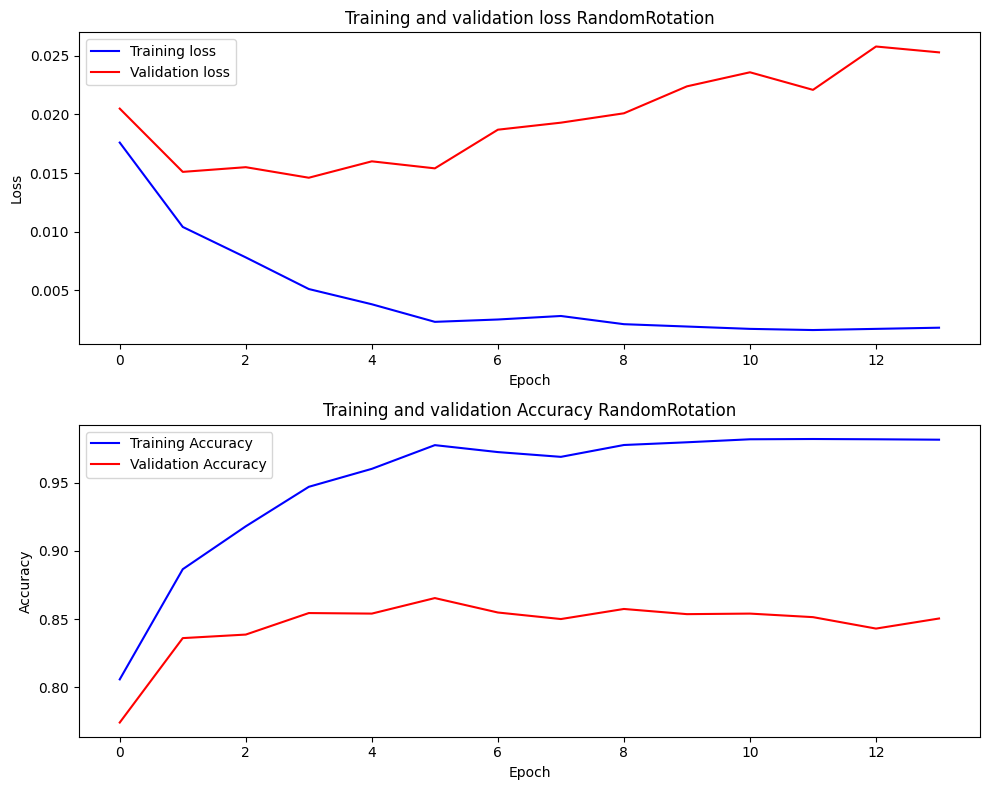

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_fr)), loss_train_log_fr, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_fr)), loss_dev_log_fr, 'r', label='Validation loss')
ax1.set_title('Training and validation loss RandomRotation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_fr)), acc_train_log_fr, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_fr)), acc_dev_log_fr, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy RandomRotation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()

In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab05/model_checkopint.pth')

In [ ]:
model_state_dict = checkpoint['model_state_dict']
model_freeze.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.8542, precision=0.8542


<Axes: title={'center': 'Confusion Matrix for acc=0.8542'}>

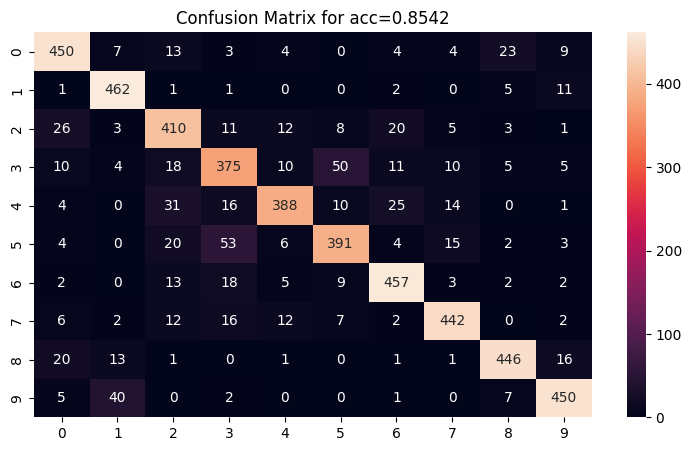

In [ ]:
y_pred, y_true = test_model(test_dl, model_freeze)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
f1_score = f1_score(y_true, y_pred, average='micro')

print(f'Accuracy={acc}, precision={precision}')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)

model z douczaniem wag

In [ ]:
model_learn.to(device)
optimizer = optim.Adam(model_learn.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

epochs_fr, loss_train_log_fr, acc_train_log_fr, loss_dev_log_fr, acc_dev_log_fr = fit(
    model_learn, optimizer, loss_fn, train_dl, val_dl, 50, 10)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss = 0.006 (acc: 0.938), validation loss = 0.017 (acc: 0.836)
Zapisujemy model z acc=0.8357999920845032, loss=0.017188547179102898, po epoce:1



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss = 0.003 (acc: 0.967), validation loss = 0.017 (acc: 0.855)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss = 0.003 (acc: 0.964), validation loss = 0.019 (acc: 0.850)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss = 0.002 (acc: 0.979), validation loss = 0.020 (acc: 0.855)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss = 0.003 (acc: 0.965), validation loss = 0.022 (acc: 0.846)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss = 0.002 (acc: 0.979), validation loss = 0.024 (acc: 0.850)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss = 0.002 (acc: 0.983), validation loss = 0.021 (acc: 0.859)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss = 0.001 (acc: 0.990), validation loss = 0.023 (acc: 0.864)
Model nie poprawił się od: 7 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss = 0.001 (acc: 0.986), validation loss = 0.024 (acc: 0.865)
Model nie poprawił się od: 8 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss = 0.001 (acc: 0.986), validation loss = 0.023 (acc: 0.856)
Model nie poprawił się od: 9 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss = 0.002 (acc: 0.983), validation loss = 0.026 (acc: 0.853)
Model nie poprawił się od: 10 epok.

Koniec uczenia


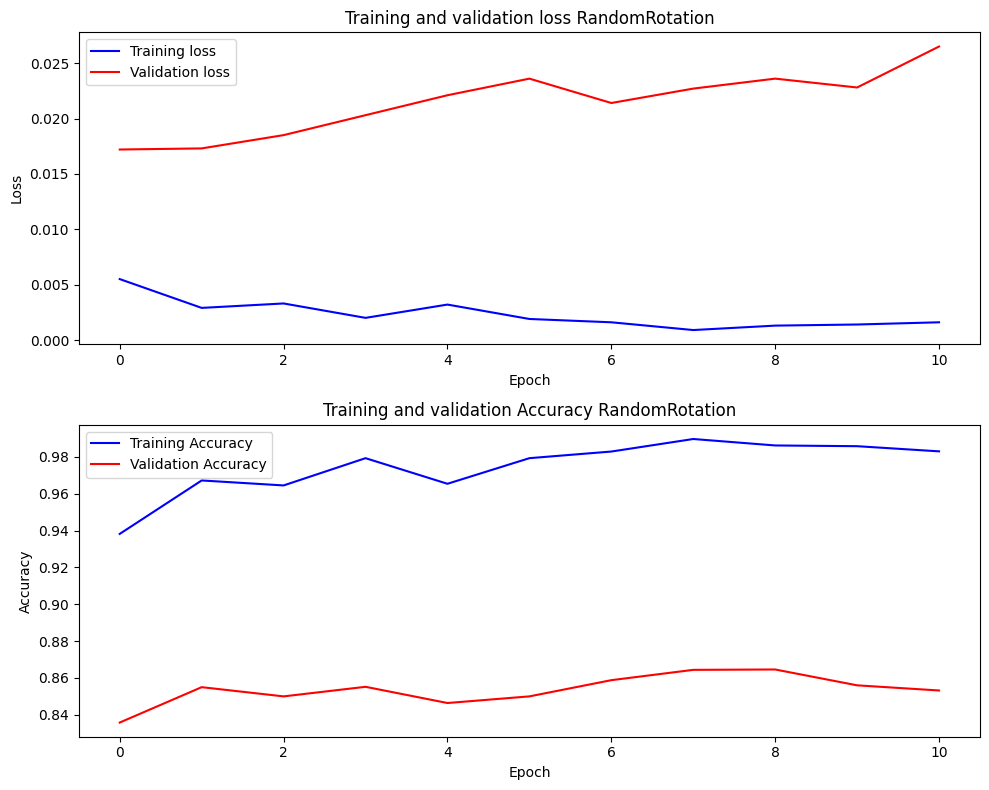

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_fr)), loss_train_log_fr, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_fr)), loss_dev_log_fr, 'r', label='Validation loss')
ax1.set_title('Training and validation loss RandomRotation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_fr)), acc_train_log_fr, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_fr)), acc_dev_log_fr, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy RandomRotation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()

In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab05/model_checkopint.pth')
model_state_dict = checkpoint['model_state_dict']
model_learn.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.8502, precision=0.8502


<Axes: title={'center': 'Confusion Matrix for acc=0.8502'}>

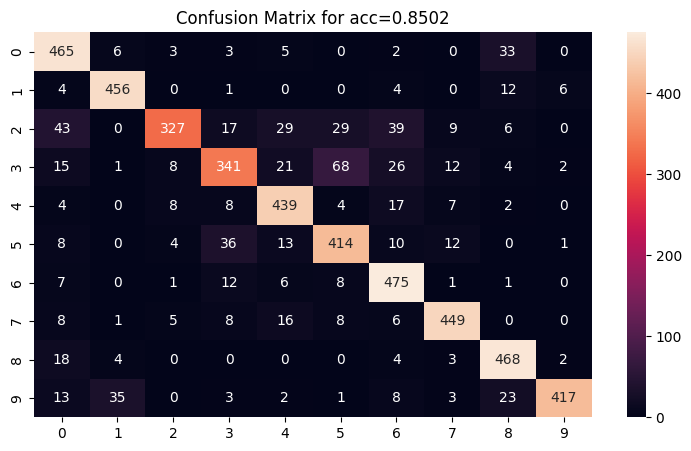

In [ ]:
y_pred, y_true = test_model(test_dl, model_freeze)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
f1_score = f1_score(y_true, y_pred, average='micro')

print(f'Accuracy={acc}, precision={precision}')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)

# Zadanie 3

Spróbuj wydobyć cechy za pomocą samodzielnie wybranego modelu dostępnego w `torchvision.models` (innego niż VGG) a następnie wyuczyć model MLP oparty o cechy na wyjściu konwolucyjnej części całej architektury. Porównaj wynik z tymi, które uzyskała sieć oparta o LabVGG19.

In [ ]:
alexnet = models.alexnet(pretrained=True)

print(alexnet)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
print(alexnet.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
class LabAlexNet(nn.Module):
    def __init__(self):
        super(LabAlexNet, self).__init__()
        self.model = alexnet.features

    def forward(self, x):
        out = self.model(x)
        out = out.view(out.size(0), -1)
        return out

class my_MLP(nn.Module):
    def __init__(self):
        super(my_MLP, self).__init__()
        self.lab_alex = LabAlexNet()
        self.fc1 = nn.Linear(6*6*256, 6*256)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(6*256, 10)

    def freeze_conv_layers(self):
        for name, param in self.named_parameters():
            # print(name, param)
            if 'conv' in name:
                param.requires_grad = False

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(227, 227)) # Zmiana rozmiaru obrazów na 227x227
        out = self.lab_alex(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [ ]:
alex_freeze = my_MLP()
alex_freeze.freeze_conv_layers()

alex_learn = my_MLP()

In [ ]:
alex_freeze

my_MLP(
  (lab_alex): LabAlexNet(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc1): Linear(in_features=9216, out_features=1536, bias=True)
  (relu): ReLU(inplace=True)
  (fc2): Linear(in_features=1536, 

In [ ]:
alex_freeze.to(device)
optimizer = optim.Adam(alex_freeze.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

epochs_fr, loss_train_log_fr, acc_train_log_fr, loss_dev_log_fr, acc_dev_log_fr = fit(
    alex_freeze, optimizer, loss_fn, train_dl, val_dl, 50, 10)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss = 0.037 (acc: 0.578), validation loss = 0.038 (acc: 0.561)
Zapisujemy model z acc=0.5607999563217163, loss=0.03817054256796837, po epoce:1



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss = 0.031 (acc: 0.650), validation loss = 0.034 (acc: 0.621)
Zapisujemy model z acc=0.6205999851226807, loss=0.033565472811460495, po epoce:2



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss = 0.028 (acc: 0.685), validation loss = 0.032 (acc: 0.644)
Zapisujemy model z acc=0.6444000005722046, loss=0.03179534524679184, po epoce:3



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss = 0.025 (acc: 0.723), validation loss = 0.030 (acc: 0.673)
Zapisujemy model z acc=0.6725999712944031, loss=0.029652714729309082, po epoce:4



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss = 0.025 (acc: 0.722), validation loss = 0.030 (acc: 0.674)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss = 0.023 (acc: 0.745), validation loss = 0.029 (acc: 0.684)
Zapisujemy model z acc=0.6841999888420105, loss=0.028885284438729286, po epoce:6



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss = 0.023 (acc: 0.745), validation loss = 0.031 (acc: 0.675)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss = 0.019 (acc: 0.781), validation loss = 0.028 (acc: 0.696)
Zapisujemy model z acc=0.6958000063896179, loss=0.028241347521543503, po epoce:8



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss = 0.020 (acc: 0.777), validation loss = 0.031 (acc: 0.686)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss = 0.019 (acc: 0.788), validation loss = 0.028 (acc: 0.699)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss = 0.022 (acc: 0.763), validation loss = 0.032 (acc: 0.678)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss = 0.020 (acc: 0.778), validation loss = 0.032 (acc: 0.681)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss = 0.019 (acc: 0.793), validation loss = 0.033 (acc: 0.683)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 14: train loss = 0.018 (acc: 0.805), validation loss = 0.030 (acc: 0.708)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 15: train loss = 0.016 (acc: 0.821), validation loss = 0.031 (acc: 0.703)
Model nie poprawił się od: 7 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 16: train loss = 0.017 (acc: 0.814), validation loss = 0.032 (acc: 0.699)
Model nie poprawił się od: 8 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 17: train loss = 0.018 (acc: 0.803), validation loss = 0.030 (acc: 0.698)
Model nie poprawił się od: 9 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 18: train loss = 0.017 (acc: 0.810), validation loss = 0.031 (acc: 0.700)
Model nie poprawił się od: 10 epok.

Koniec uczenia


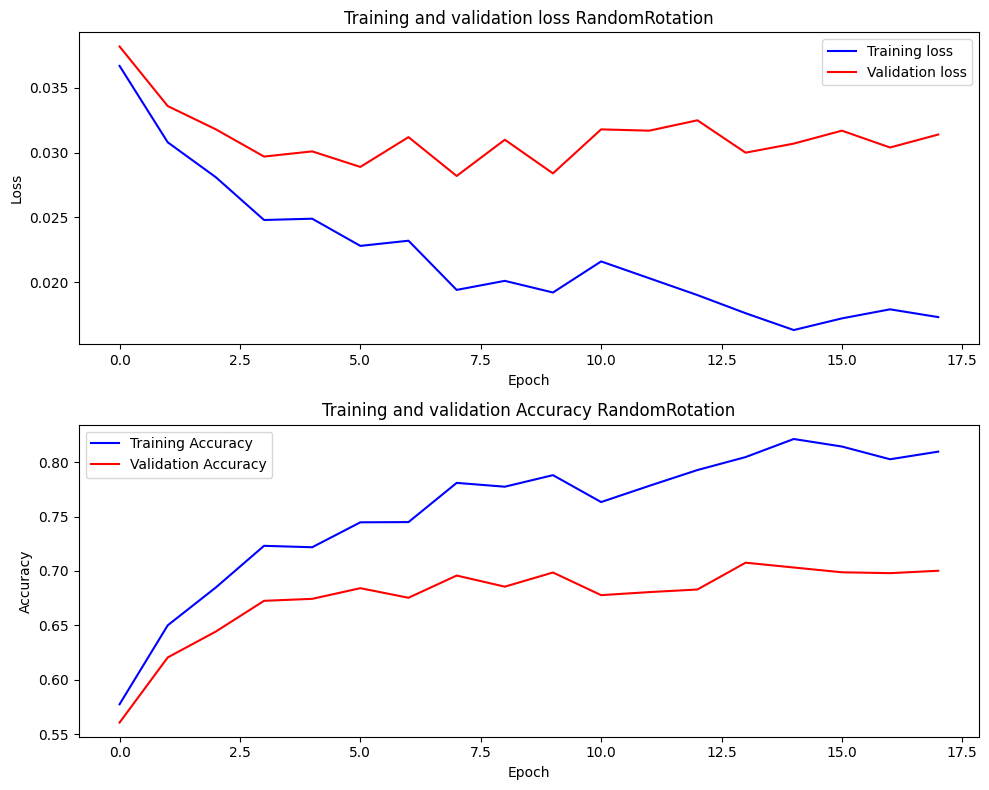

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_fr)), loss_train_log_fr, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_fr)), loss_dev_log_fr, 'r', label='Validation loss')
ax1.set_title('Training and validation loss RandomRotation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_fr)), acc_train_log_fr, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_fr)), acc_dev_log_fr, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy RandomRotation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()

In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab05/model_checkopint.pth')
model_state_dict = checkpoint['model_state_dict']
alex_freeze.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.704, precision=0.704


<Axes: title={'center': 'Confusion Matrix for acc=0.704'}>

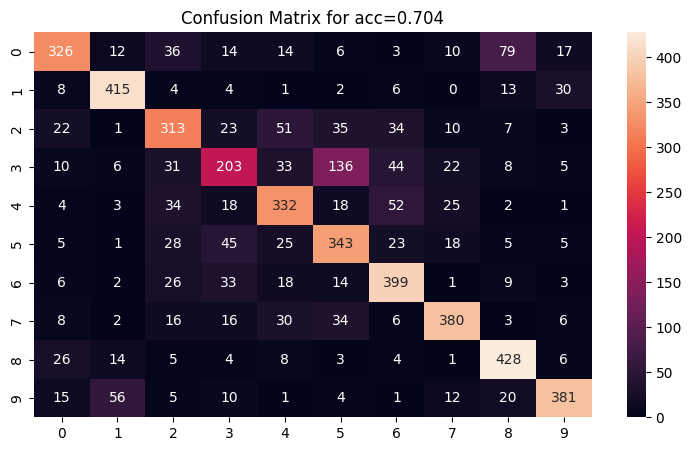

In [ ]:
y_pred, y_true = test_model(test_dl, alex_freeze)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
# f1_score = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy={acc}, precision={precision}')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)

In [ ]:
alex_learn.to(device)
optimizer = optim.Adam(alex_learn.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

epochs_fr, loss_train_log_fr, acc_train_log_fr, loss_dev_log_fr, acc_dev_log_fr = fit(
    alex_learn, optimizer, loss_fn, train_dl, val_dl, 50, 10)

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1: train loss = 0.024 (acc: 0.737), validation loss = 0.031 (acc: 0.692)
Zapisujemy model z acc=0.69159996509552, loss=0.03060414083302021, po epoce:1



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2: train loss = 0.022 (acc: 0.756), validation loss = 0.029 (acc: 0.696)
Zapisujemy model z acc=0.6961999535560608, loss=0.028736233711242676, po epoce:2



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3: train loss = 0.020 (acc: 0.781), validation loss = 0.028 (acc: 0.717)
Zapisujemy model z acc=0.717199981212616, loss=0.02750682272017002, po epoce:3



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4: train loss = 0.022 (acc: 0.754), validation loss = 0.029 (acc: 0.687)
Model nie poprawił się od: 1 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 5: train loss = 0.019 (acc: 0.793), validation loss = 0.029 (acc: 0.715)
Model nie poprawił się od: 2 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 6: train loss = 0.019 (acc: 0.793), validation loss = 0.030 (acc: 0.700)
Model nie poprawił się od: 3 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 7: train loss = 0.018 (acc: 0.804), validation loss = 0.031 (acc: 0.705)
Model nie poprawił się od: 4 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 8: train loss = 0.017 (acc: 0.810), validation loss = 0.029 (acc: 0.706)
Model nie poprawił się od: 5 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 9: train loss = 0.017 (acc: 0.810), validation loss = 0.031 (acc: 0.712)
Model nie poprawił się od: 6 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 10: train loss = 0.016 (acc: 0.819), validation loss = 0.030 (acc: 0.710)
Model nie poprawił się od: 7 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 11: train loss = 0.016 (acc: 0.822), validation loss = 0.031 (acc: 0.719)
Model nie poprawił się od: 8 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 12: train loss = 0.016 (acc: 0.826), validation loss = 0.033 (acc: 0.710)
Model nie poprawił się od: 9 epok.



  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 13: train loss = 0.015 (acc: 0.839), validation loss = 0.031 (acc: 0.721)
Model nie poprawił się od: 10 epok.

Koniec uczenia


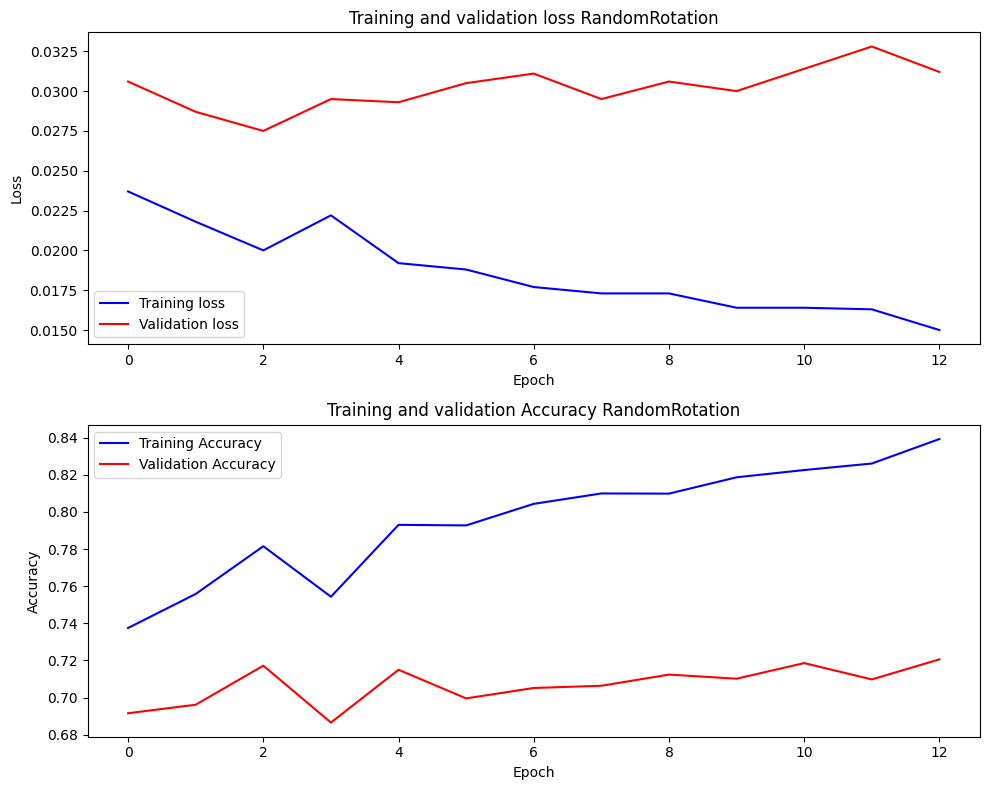

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))
ax1.plot(np.arange(len(loss_train_log_fr)), loss_train_log_fr, 'b', label='Training loss')
ax1.plot(np.arange(len(loss_train_log_fr)), loss_dev_log_fr, 'r', label='Validation loss')
ax1.set_title('Training and validation loss RandomRotation')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
leg = ax1.legend()
ax1.set

ax2.plot(np.arange(len(loss_train_log_fr)), acc_train_log_fr, 'b', label='Training Accuracy')
ax2.plot(np.arange(len(loss_train_log_fr)), acc_dev_log_fr, 'r', label='Validation Accuracy')
ax2.set_title('Training and validation Accuracy RandomRotation')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
leg = ax2.legend()

ax2.set

plt.tight_layout()

In [ ]:
checkpoint= torch.load('/content/drive/MyDrive/lab05/model_checkopint.pth')
model_state_dict = checkpoint['model_state_dict']
alex_learn.load_state_dict(model_state_dict)

<All keys matched successfully>

Accuracy=0.7154, precision=0.7154


<Axes: title={'center': 'Confusion Matrix for acc=0.7154'}>

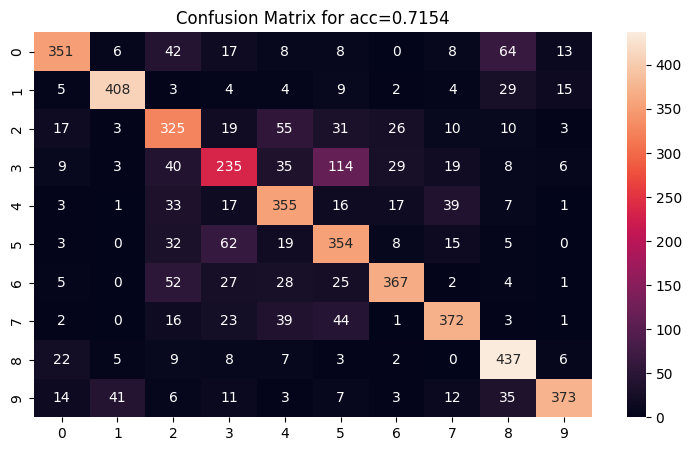

In [ ]:
y_pred, y_true = test_model(test_dl, alex_learn)

acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
# f1_score = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy={acc}, precision={precision}')
fig, ax = plt.subplots(figsize=(9,5))
cm = confusion_matrix(y_true, y_pred)

ax.set_title(f'Confusion Matrix for acc={acc}')

sns.heatmap(cm, annot=True, ax=ax, fmt=',d', figure=fig)